# Boosting Classifier for predicting client subscription for a marketing campaign

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
%matplotlib inline
from sklearn import metrics
## Importing GridSearchCV
from sklearn.model_selection import GridSearchCV

In [2]:
bank_df = pd.read_csv( 'bank.csv' ) 
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4521 entries, 0 to 4520
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   age                4521 non-null   int64 
 1   job                4521 non-null   object
 2   marital            4521 non-null   object
 3   education          4521 non-null   object
 4   default            4521 non-null   object
 5   balance            4521 non-null   int64 
 6   housing-loan       4521 non-null   object
 7   personal-loan      4521 non-null   object
 8   current-campaign   4521 non-null   int64 
 9   previous-campaign  4521 non-null   int64 
 10  subscribed         4521 non-null   object
dtypes: int64(4), object(7)
memory usage: 388.6+ KB


In [3]:
bank_df.head(5)

,age,job,marital,education,default,balance,housing-loan,personal-loan,current-campaign,previous-campaign,subscribed
0,30,unemployed,married,primary,no,1787,no,no,1,0,no
1,33,services,married,secondary,no,4789,yes,yes,1,4,no
2,35,management,single,tertiary,no,1350,yes,no,1,1,no
3,30,management,married,tertiary,no,1476,yes,yes,4,0,no
4,59,blue-collar,married,secondary,no,0,yes,no,1,0,no


In [4]:
bank_df.subscribed.value_counts()

no     4000
yes     521
Name: subscribed, dtype: int64

In [5]:
# Checking data balance/proportion
campaign = bank_df.subscribed.value_counts().to_frame().rename(columns={"subscribed":"absolute"})
campaign["percent"] = (campaign.apply(lambda x: x/x.sum()*100).round(2))
display(campaign)

,absolute,percent
no,4000,88.48
yes,521,11.52


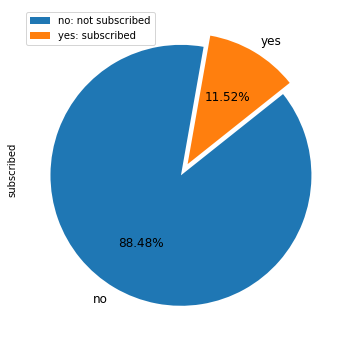

In [6]:
# pie chart
bank_df.subscribed.value_counts().plot(kind='pie', subplots=True, autopct='%1.2f%%', explode= (0.05, 0.05), startangle=80, legend=True, fontsize=12, figsize=(14,6), textprops={'color':"black"})
plt.legend(["no: not subscribed","yes: subscribed"]);

### Data Resampling

In [7]:
## Importing resample from *sklearn.utils* package. 
from sklearn.utils import resample

# Separate the case of yes-subscribes and no-subscribes 
bank_subscribed_no = bank_df[bank_df.subscribed == 'no'] 
bank_subscribed_yes = bank_df[bank_df.subscribed == 'yes']

##Upsample the yes-subscribed cases.
df_minority_upsampled = resample(bank_subscribed_yes,replace=True, n_samples=2000)

# Combine majority class with upsampled minority class
new_bank_df = pd.concat([bank_subscribed_no, df_minority_upsampled])


In [8]:
from sklearn.utils import shuffle 
new_bank_df = shuffle(new_bank_df)

In [9]:
# Assigning list of all column names in the DataFrame
X_features = list( new_bank_df.columns )
# Remove the response variable from the list
X_features.remove( 'subscribed' ) 
X_features


['age',
 'job',
 'marital',
 'education',
 'default',
 'balance',
 'housing-loan',
 'personal-loan',
 'current-campaign',
 'previous-campaign']

In [10]:
## get_dummies() will convert all the columns with data type as objects 
encoded_bank_df = pd.get_dummies( new_bank_df[X_features], drop_first = True ) 
X = encoded_bank_df
X.columns

Index(['age', 'balance', 'current-campaign', 'previous-campaign',
       'job_blue-collar', 'job_entrepreneur', 'job_housemaid',
       'job_management', 'job_retired', 'job_self-employed', 'job_services',
       'job_student', 'job_technician', 'job_unemployed', 'job_unknown',
       'marital_married', 'marital_single', 'education_secondary',
       'education_tertiary', 'education_unknown', 'default_yes',
       'housing-loan_yes', 'personal-loan_yes'],
      dtype='object')

In [11]:
# Encoding the subscribed column and assigning to Y
Y = new_bank_df.subscribed.map( lambda x: int( x == 'yes') )
print((Y==1).sum())

2000


In [12]:
print((Y==0).sum())

4000


In [13]:
from sklearn.model_selection import train_test_split

train_X, test_X, train_y, test_y = train_test_split( X,Y,
        test_size = 0.3, random_state = 42 )


# Ensemble Methods: Boosting

In [14]:
## Defining the matrix to draw the confusion metrix from actual and predicted cl ass labels
def draw_cm( actual, predicted ):
    # Invoking confusion_matrix from metric package. The matrix will oriented as [1,0] i.e.
    # the classes with label 1 will be reprensted the first row and 0 as second row
    cm = metrics.confusion_matrix( actual, predicted, [1,0] )
    ## Confustion will be plotted as heatmap for better visualization ## The lables are configured to better interpretation from the plot 
    sn.heatmap(cm, annot=True, fmt='.2f',
            xticklabels = ["Subscribed", "Not Subscribed"], yticklabels = ["Subscribed", "Not Subscribed"] )

In [15]:
def draw_roc_curve( model, test_X, test_y ):
    ## Creating and initializing a results DataFrame with actual labels 
    test_results_df = pd.DataFrame( { 'actual':	test_y } ) 
    test_results_df = test_results_df.reset_index()

    # predict the probabilities on the test set
    predict_proba_df = pd.DataFrame( model.predict_proba( test_X ) )

    ## selecting the probabilities that the test example belongs to class 1
    test_results_df['chd_1'] = predict_proba_df.iloc[:,1:2]


    ## Invoke roc_curve() to return the fpr, tpr and threshold values. 
    ## threshold values contain values from 0.0 to 1.0
    fpr, tpr, thresholds = metrics.roc_curve( test_results_df.actual,
    test_results_df.chd_1, drop_intermediate = False )

    ## Getting the roc auc score by invoking metrics.roc_auc_score method
    auc_score = metrics.roc_auc_score( test_results_df.actual, test_results_df.chd_1)

    ## Setting the size of the plot
    plt.figure(figsize=(8, 6))
    ## plotting the actual fpr and tpr values
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    ## plotting th diagnoal line from (0,1)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    ## Setting labels and titles
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]') 
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example') 
    plt.legend(loc="lower right")
    plt.show()

    return auc_score, fpr, tpr, thresholds

### Use logistic regression  as base classifier

In [16]:
from sklearn.linear_model import LogisticRegression

## Initializing the model
logit = LogisticRegression()
## Fitting the model with X and Y values of the dataset
logit.fit( train_X, train_y)

LogisticRegression()

# Ada Boosting Classifier

In [17]:
## Importing Adaboost classifier
from sklearn.ensemble import AdaBoostClassifier

## Initializing logistic regression to use as base classifier
logreg_clf = LogisticRegression()

## Initilizing adaboost classifier with 50 classifers
ada_clf = AdaBoostClassifier(logreg_clf, n_estimators=50)

## Fitting adaboost model to training set
ada_clf.fit(train_X, train_y )


AdaBoostClassifier(base_estimator=LogisticRegression())

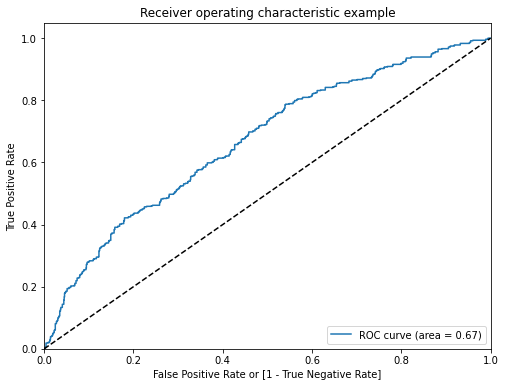

In [18]:
_, _, _, _ = draw_roc_curve( ada_clf, test_X, test_y )

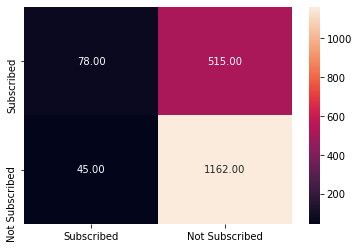

In [19]:
ada_clf.fit(train_X, train_y ) 
pred_y = ada_clf.predict( test_X ) 
draw_cm( test_y, pred_y )

In [20]:
print( metrics.classification_report( test_y, pred_y ) )

              precision    recall  f1-score   support

           0       0.69      0.96      0.81      1207
           1       0.63      0.13      0.22       593

    accuracy                           0.69      1800
   macro avg       0.66      0.55      0.51      1800
weighted avg       0.67      0.69      0.61      1800



# Gradient Boosting

In [21]:
## Importing Gradient Boosting classifier
from sklearn.ensemble import GradientBoostingClassifier

## Initializing Gradient Boosting with 500 estimators and max depth as 10.
gboost_clf = GradientBoostingClassifier( n_estimators=500, max_depth=10)

## Fitting gradient boosting model to training set
gboost_clf.fit(train_X, train_y )


GradientBoostingClassifier(max_depth=10, n_estimators=500)

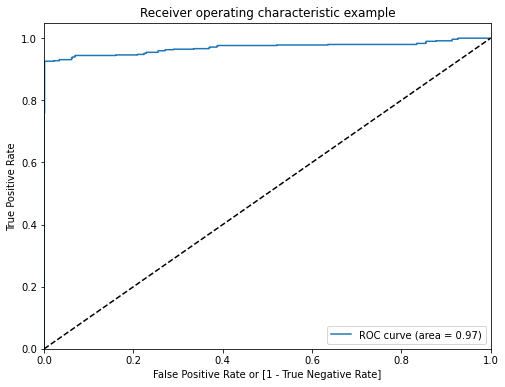

In [22]:
_, _, _, _ = draw_roc_curve( gboost_clf, test_X, test_y )

In [23]:
from sklearn.model_selection import cross_val_score

gboost_clf = GradientBoostingClassifier( n_estimators=500, max_depth=10) 
cv_scores = cross_val_score( gboost_clf, train_X, train_y, cv = 10, scoring = 'roc_auc' )
print( cv_scores )
print( "Mean Accuracy: ", np.mean(cv_scores), " with standard deviation of: ", np.std(cv_scores))


[0.98081633 0.93211735 0.96278061 0.96542871 0.9695976  0.97180915
 0.97686774 0.96522535 0.96931798 0.94491472]
Mean Accuracy:  0.9638875525196733  with standard deviation of:  0.013980769477754071


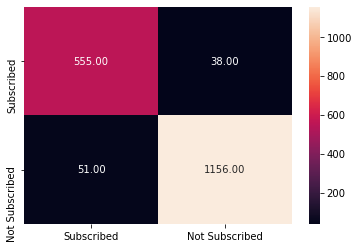

In [24]:
gboost_clf.fit(train_X, train_y ) 
pred_y = gboost_clf.predict( test_X ) 
draw_cm( test_y, pred_y )

In [25]:
print( metrics.classification_report( test_y, pred_y ) )

              precision    recall  f1-score   support

           0       0.97      0.96      0.96      1207
           1       0.92      0.94      0.93       593

    accuracy                           0.95      1800
   macro avg       0.94      0.95      0.94      1800
weighted avg       0.95      0.95      0.95      1800



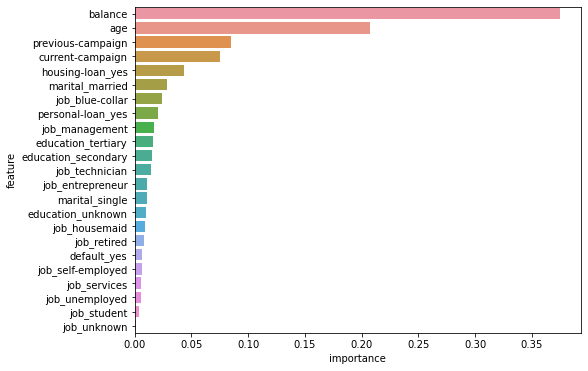

In [26]:
import numpy as np

# Create a dataframe to store the featues and their corresponding importances
feature_rank = pd.DataFrame( { 'feature': train_X.columns,
'importance': gboost_clf.feature_importances_ } )

## Sorting the features based on their importances with most important feature a t top.
feature_rank = feature_rank.sort_values('importance', ascending = False)

plt.figure(figsize=(8, 6))
# plot the values
sn.barplot( y = 'feature', x = 'importance', data = feature_rank );


# XG Boost

In [17]:
## Importing XG Boosting classifier
from xgboost import XGBClassifier
## Initializing XG Boosting with 500 estimators and max depth as 10.
xgboost_clf = XGBClassifier( n_estimators=500, max_depth=10)

## Fitting gradient boosting model to training set
xgboost_clf.fit(train_X, train_y )


[23:13:54] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=500, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

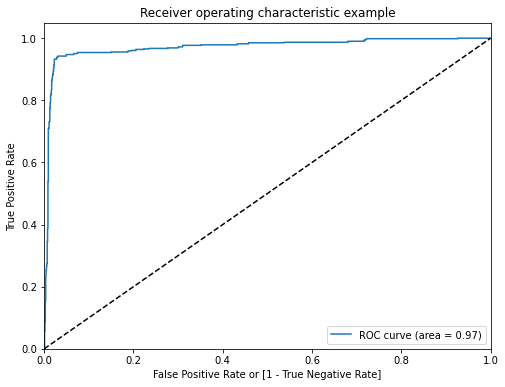

In [18]:
_, _, _, _ = draw_roc_curve( xgboost_clf, test_X, test_y )

In [19]:
from sklearn.model_selection import cross_val_score

xgboost_clf = XGBClassifier( n_estimators=500, max_depth=10) 
cv_scores = cross_val_score( xgboost_clf, train_X, train_y, cv = 10, scoring = 'roc_auc' )
print( cv_scores )
print( "Mean Accuracy: ", np.mean(cv_scores), " with standard deviation of: ", np.std(cv_scores))

[23:13:55] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:57] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[23:13:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

[23:14:04] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


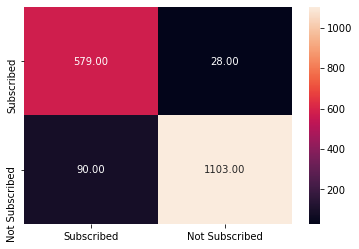

In [20]:
xgboost_clf.fit(train_X, train_y ) 
pred_y = xgboost_clf.predict( test_X ) 
draw_cm( test_y, pred_y )

In [31]:
print( metrics.classification_report( test_y, pred_y ) )

              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1207
           1       0.86      0.93      0.89       593

    accuracy                           0.93      1800
   macro avg       0.91      0.93      0.92      1800
weighted avg       0.93      0.93      0.93      1800

